### Setup

In [1]:
import pandas as pd
import scipy as sc
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
plt.rcParams['figure.dpi'] = 200

%pip install seaborn | grep -v 'already satisfied'
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [2]:
full_data = pd.read_csv('../data/cleaned/language_data.csv')
sample200 = pd.read_csv('../data/cleaned/200-language-sample.csv')

### To cluster or not to cluster?

Initially, our goal here was to partition by linguistic properties and see how the clusters match up to their natural clusters (i.e., linguistic families). 

Unfortunately, the results suggest that the standard clustering models are a poor fit for our data——where the main features are all categorical. We'll demonstrate this an abbreviated exploration of trying to cluster the data

In [3]:
def filter_and_reshape(data, *, verbose = 0): 
	"""
	Filters the given dataframe by those languages belonging to families with 
	at least 2 languages and subsets the columns to the main linguistic features. 

	Returns a triple of `(fd, families, meta_info, n_families)` where: 
		`fd`: is a dataframe consisting of the names and feature columns only
		`families`: a categorical series of the 'family' for this subset of the data
		`meta_info`: a dataframe containing the WALS code, geographic coordinates, macroarea, etc. 
		`n_families`: the number of unique families in this subset
	"""
	df = data.copy()
	families = df['family'].astype('category')

	# Store the original count so that we know how many columns to skip 
	# before the feature columns begin. 
	N = families.cat.categories.size

	if verbose: 
		print('number of families:', N)

	# Restrict to families with at least 2 languages represented in the dataset
	counts = families.value_counts()
	more_than_1 = counts[counts > 1]
	df = df[df['family'].isin(more_than_1.index)].reset_index(drop = 1)
	families = df['family'].astype('category')
	n_families = families.cat.categories.size

	if verbose: 
		print('number of families (with >1 lang):', n_families)
		print()
		display(families.value_counts())

	# First 10 columns are meta info, followed by N one-hot encoded family columns, 
	# followed by the one-hot feature columns
	meta_info, feature_data = df.iloc[:, :10], df.iloc[:, (10+N):]
	family_columns = df.iloc[:, 10:(10+N)]

	# Ignore `nan` columns
	columnset = [c for c in feature_data.columns if not c.endswith('_nan')]
	fd = feature_data[columnset]

	if verbose:
		# sanity check: every language has a unique set of feature values
		print()
		print('duplicate rows:', any(fd.duplicated()))

	# Join names to feature data to use as index if needed
	names = meta_info['Name']
	fd = pd.concat([names, fd] , axis = 'columns')
	fd.set_index('Name', inplace = True)

	if verbose: 
		display(fd.reset_index())

	return fd, families, meta_info, n_families

# Use the 200-lang sample because the full dataset does, in fact, have duplicate feature rows. 
fd, families, meta_info, n_families = filter_and_reshape(sample200)
n_families

24

First 10 Explained variance ratios:
	[0.0804 0.0614 0.0406 0.0361 0.0323 0.0236 0.0213 0.0204 0.019  0.0179]
First 10 Cumulative ratios:
	[0.0804 0.1418 0.1825 0.2185 0.2508 0.2744 0.2958 0.3162 0.3351 0.353 ]


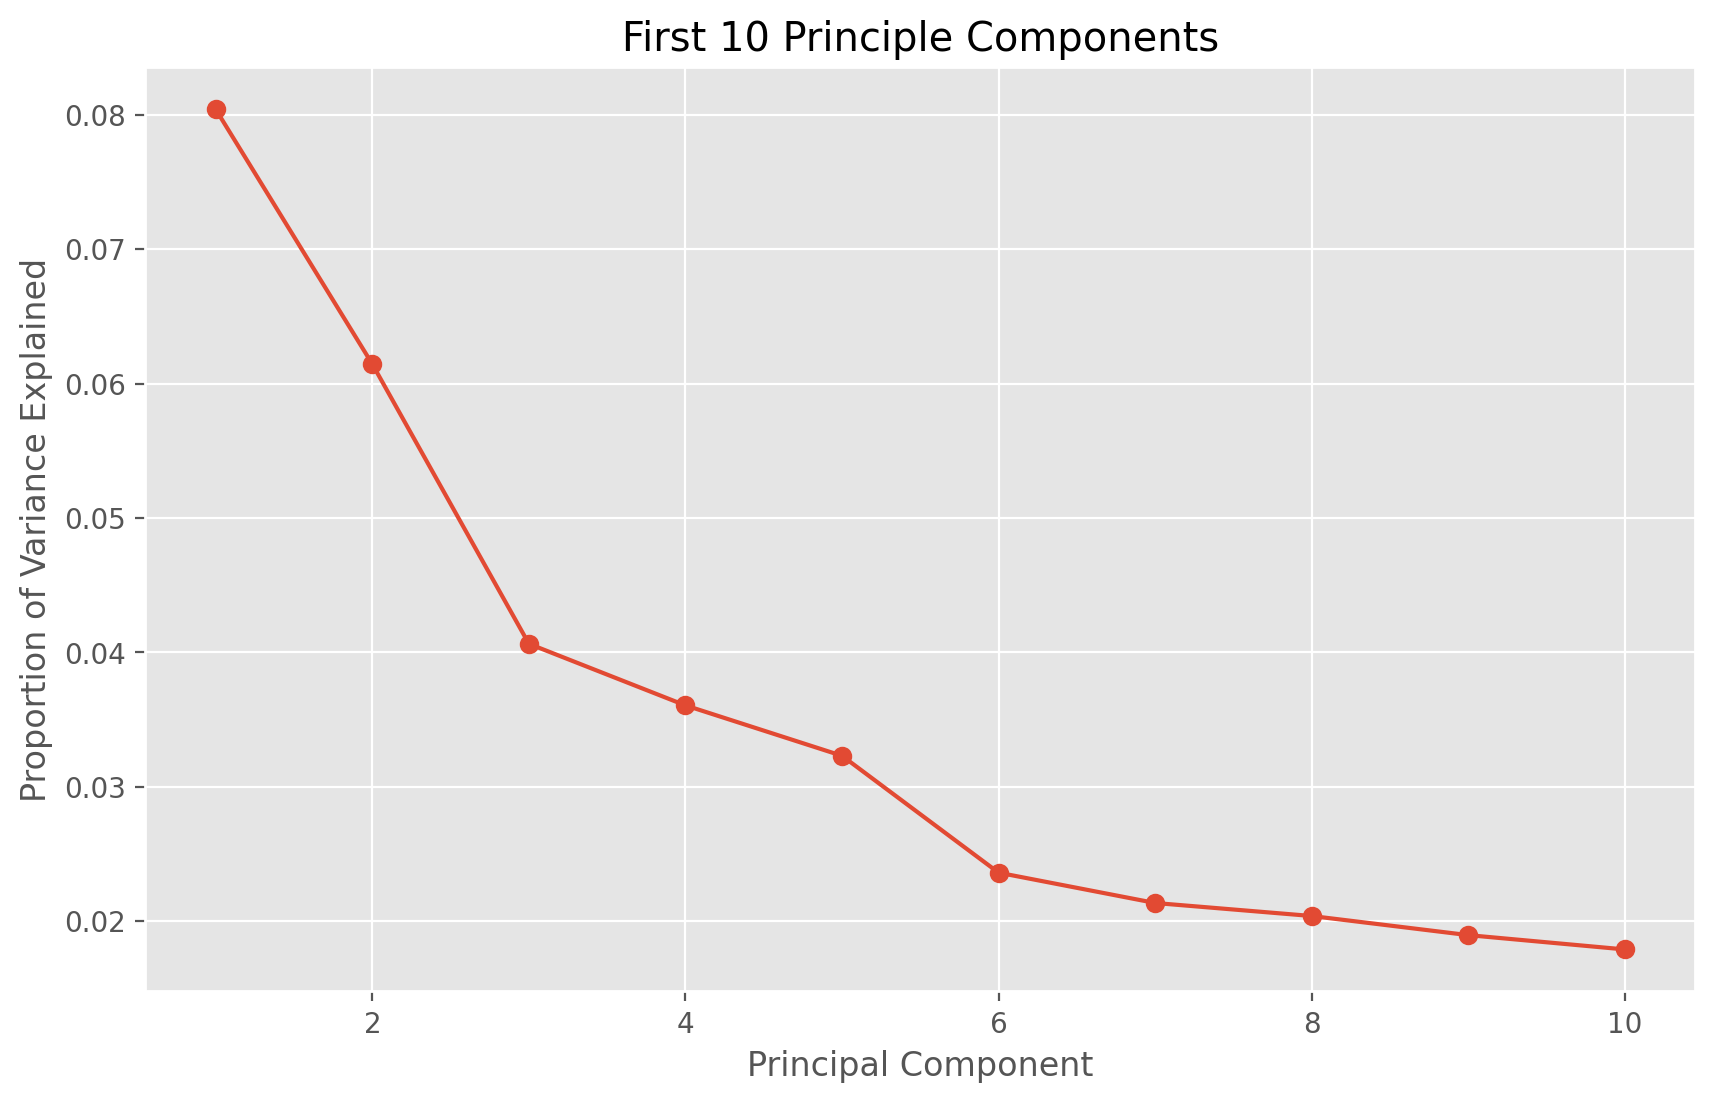

In [4]:
def try_pca(X): 
	pca_model = PCA() # don't inline; need this later to access explained variance
	pca_array = pca_model.fit_transform(X)
	nrows, ncols = pca_array.shape
	pc_columns = [f'PC{i}' for i in range(1, ncols + 1)]

	pca_sfd = pd.DataFrame(pca_array, columns = pc_columns, index = meta_info['Name'])
	pca_sfd.head()

	# Variance ratio of the first (up to) 10 principal components
	var_ratio = pca_model.explained_variance_ratio_
	n = min(10, X.shape[1])
	print(f'First {n} Explained variance ratios:', var_ratio[:n].round(4), sep = '\n\t')
	print(f'First {n} Cumulative ratios:', var_ratio.cumsum()[:n].round(4), sep = '\n\t')

	x = range(1, len(var_ratio) + 1)

	def pca_var_plot(x, var_ratio, n, *, force_it = 0): 
		assert n > 1, '`n` must be greater than 1'
		ncols = X.shape[1]

		if n > ncols and not force_it: 
			return
		
		n = min(n, ncols)
		plt.plot(x[:n], var_ratio[:n], '-o')
		plt.ylabel('Proportion of Variance Explained')
		plt.xlabel('Principal Component')
		plt.title(f'First {n} Principle Components')
		plt.show()

	# pca_var_plot(x, var_ratio, 100)
	# pca_var_plot(x, var_ratio, 40)
	pca_var_plot(x, var_ratio, 10, force_it = True)

try_pca(fd)

#### PCA? 

It looks like there are too many feature columns (over 1000 for the one-hot encoded data) for PCA to be useful here. Even the first PC has a variance ratio of only $≈ 0.08$. We would have to take a lot of PCs in order to accumulate a majority variance ratio, which defeats the purpose of dimensionality reduction. 

On the other hand, if we restrict features by some other means (e.g., using only grammatical or phonological features), then `PCA` may prove fruitful. 

For an attempt at clustering, we'll use `OPTICS` which is similar to `DBSCAN`. 

In [11]:
def try_cluster(X, families): 
	boolean_metrics = [
		'dice',
		'hamming',
		'jaccard',
		'rogerstanimoto',
		'russellrao',
		'sokalsneath',
		'yule'
	]

	for metric in boolean_metrics: 
		model = OPTICS(min_samples = 2, metric = metric)
		y = model.fit_predict(X.astype(bool))
		h, c, v = metrics.homogeneity_completeness_v_measure(y, families)
		print(metric)
		print(f'    {h:.4f}, {c:.4f}, {v:.4f}')
		print()

	print('— — —')
	print()

	# KMeans for comparison
	n_families = families.cat.categories.size
	model = KMeans(n_clusters = n_families, init = 'random', n_init = 10)
	y_km = model.fit_predict(X)
	h, c, v = metrics.homogeneity_completeness_v_measure(y, families)
	print('kmeans')
	print(f'    {h:.4f}, {c:.4f}, {v:.4f}')

try_cluster(fd.values, families)

dice
    0.6416, 0.3851, 0.4813

hamming
    0.5825, 0.2772, 0.3757

jaccard
    0.6490, 0.3087, 0.4184

rogerstanimoto
    0.5948, 0.2610, 0.3628

russellrao
    1.0000, 0.0000, 0.0000

sokalsneath
    0.6280, 0.2009, 0.3044

yule
    0.6108, 0.4828, 0.5393

— — —

kmeans
    0.6108, 0.4828, 0.5393


#### Discussion

Even using boolean metrics, the results are quite poor. In fact, none have better v-measure than `KMeans`, which requires a meaningful Euclidean distance to produce sensible results. 

#### K-search

In [6]:
X = fd
ks = range(2, len(X)//2)
scores = []
silhouette_avg = []

for k in ks:
	model = KMeans(n_clusters = k, init = 'random', n_init = 10, random_state = 1)
	y_km = model.fit_predict(X)
	scores.append(-model.score(X))
	silhouette_avg.append(metrics.silhouette_score(X, y_km))

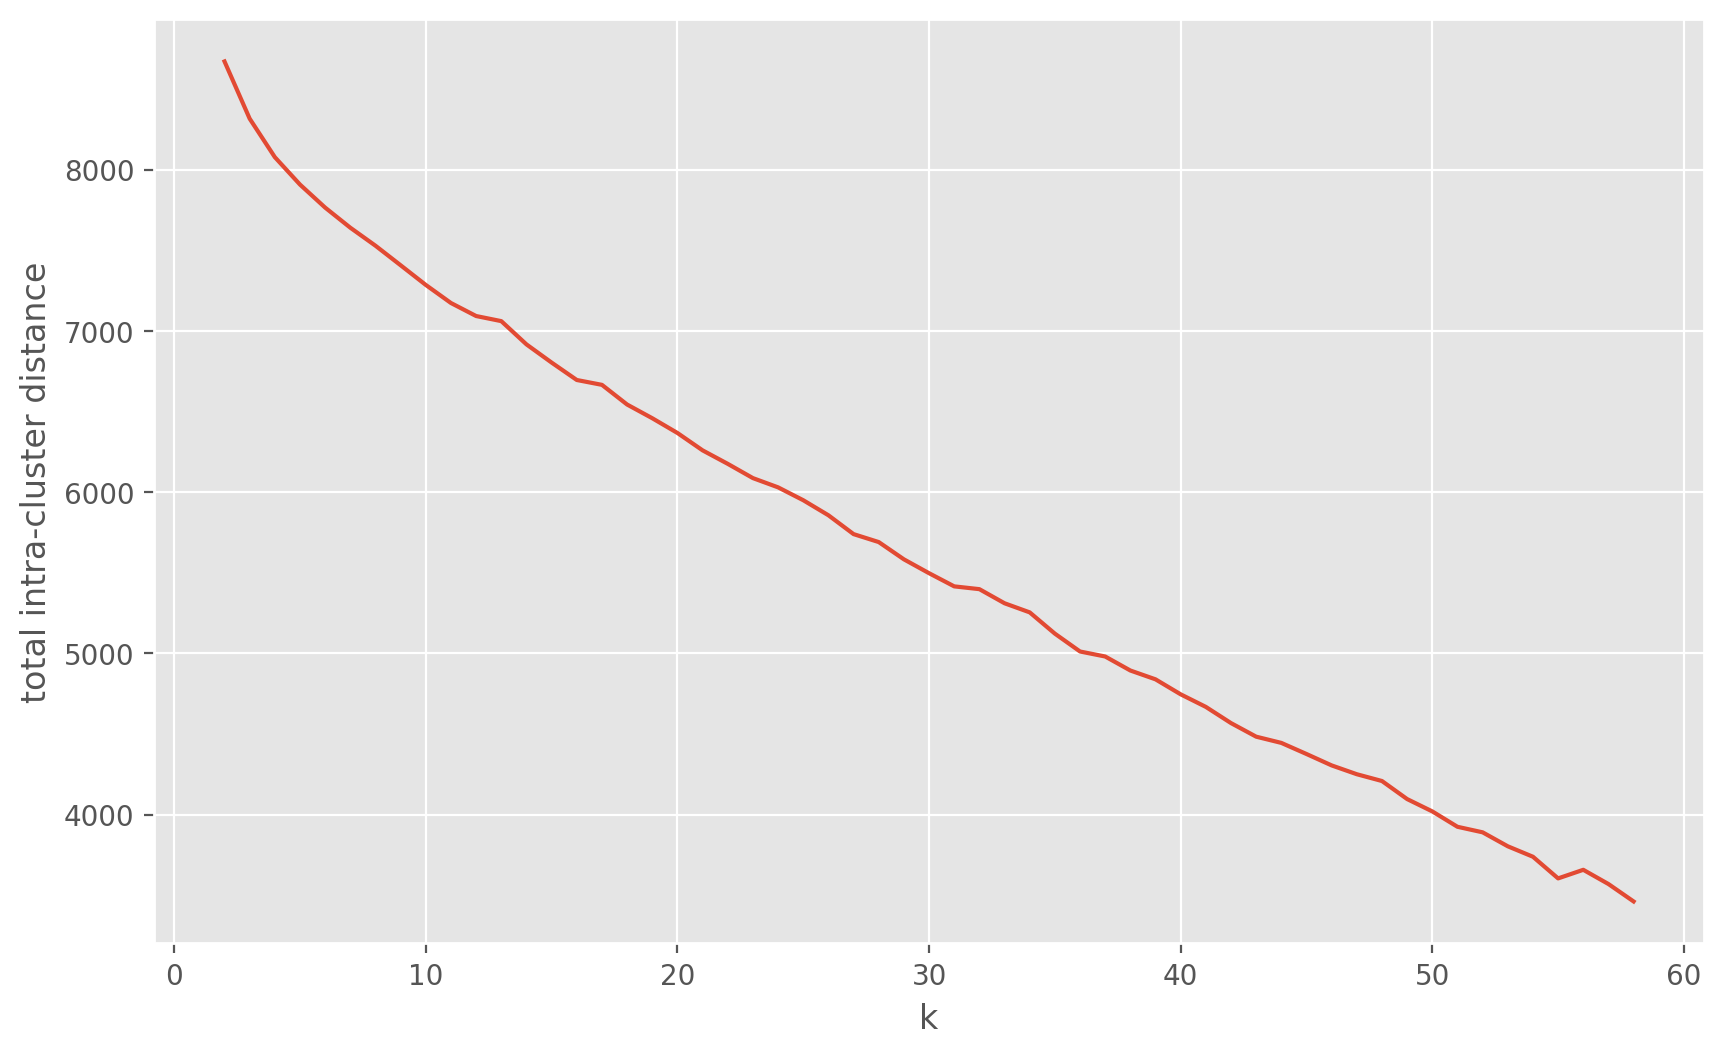

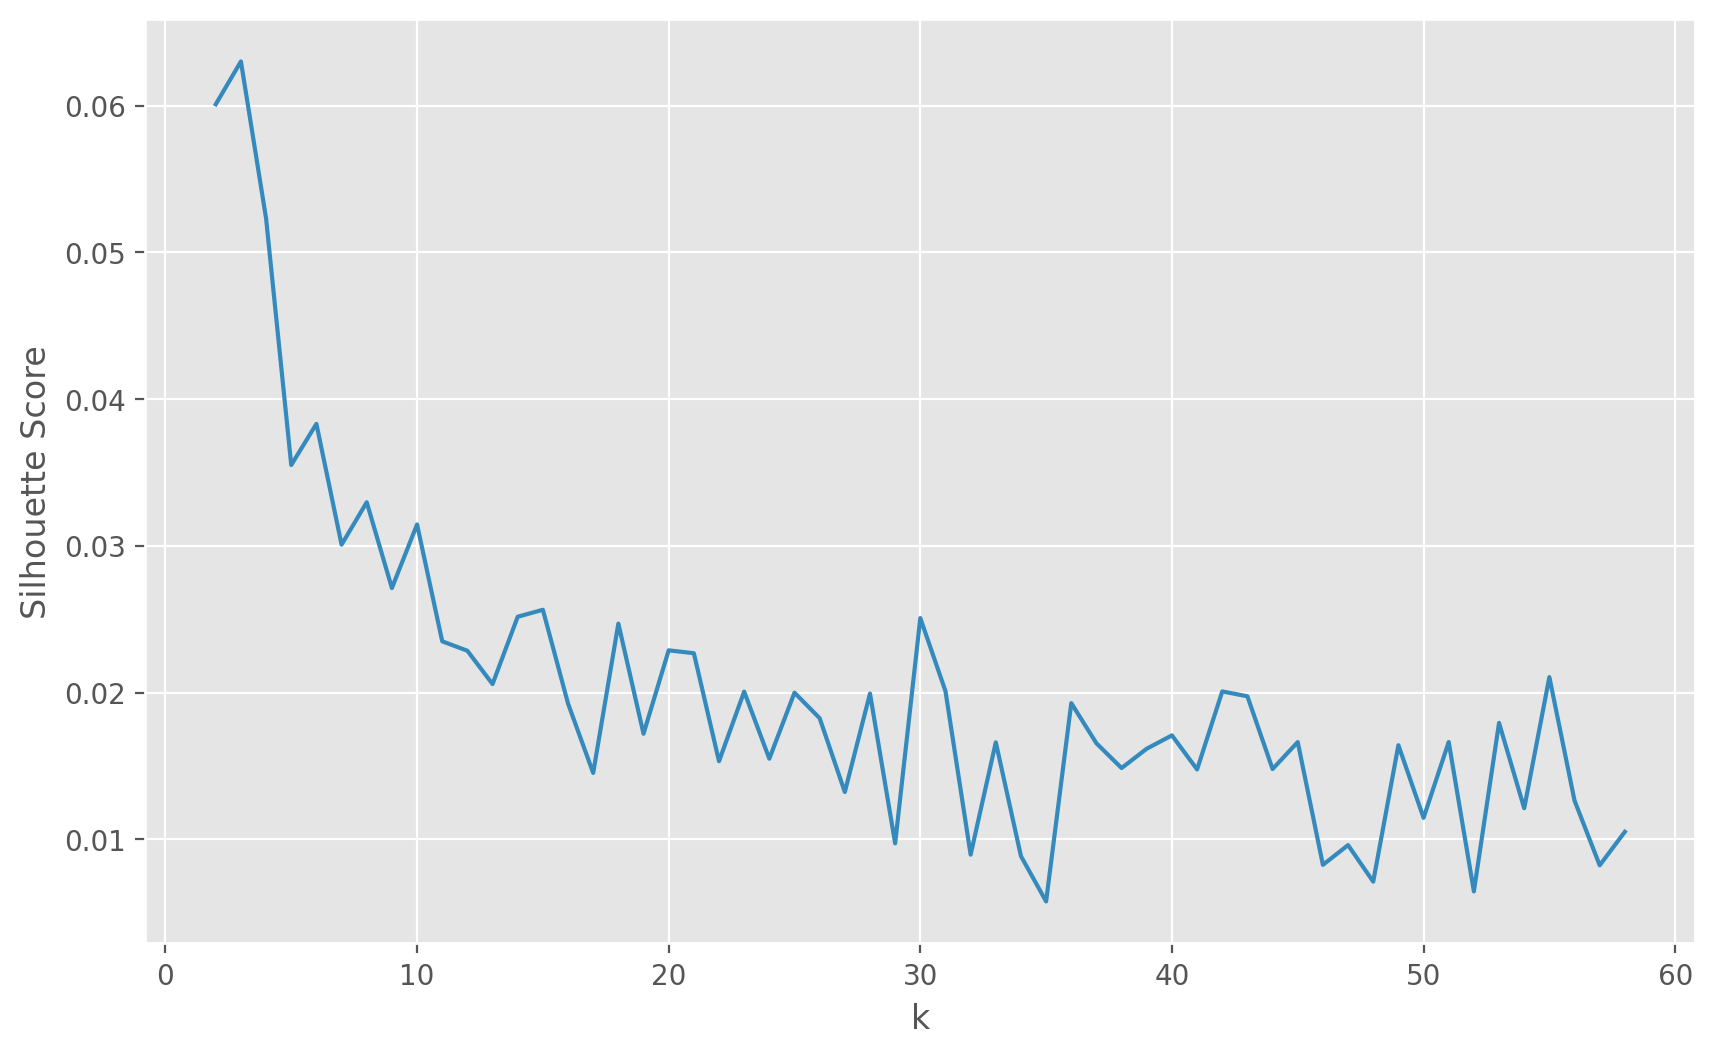

In [7]:
plt.plot(ks[:len(scores)], scores, color = 'C0')
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
#plt.xticks(ks)

plt.figure()
plt.plot(ks[:len(silhouette_avg)], silhouette_avg, color = 'C1')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
#plt.xticks(ks)

plt.show()